# Gaussian Mixtures

Sometimes, our data look like they are generated by a "mixture" model. What do we mean by that? In statistics land, it means we believe that there are "mixtures" of subpopulations generating the data that we observe. A common activity, then, is to estimate the subpopulation parameters.

Let's take a look at it by generating some simulated data to illustrate the point.

In [1]:
import sys
sys.executable

'/home/ericmjl/anaconda/envs/bayesian/bin/python'

In [2]:
import numpy as np
import pymc3 as pm
import matplotlib.pyplot as plt

%load_ext autoreload
%autoreload 2
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

WARNING (theano.sandbox.cuda): The cuda backend is deprecated and will be removed in the next release (v0.10).  Please switch to the gpuarray backend. You can get more information about how to switch at this URL:
 https://github.com/Theano/Theano/wiki/Converting-to-the-new-gpu-back-end%28gpuarray%29

Using gpu device 0: GeForce GTX 1080 (CNMeM is disabled, cuDNN Mixed dnn version. The header is from one version, but we link with a different version (5110, 6021))


We will start by first generating a mixture distribution that is composed of unit width Gaussians (i.e. $ N(\mu, 1) $) that are slightly overlapping.

$$ pop \sim GaussianMixture(\mu=[0, 3], \sigma=[1, 1]) $$

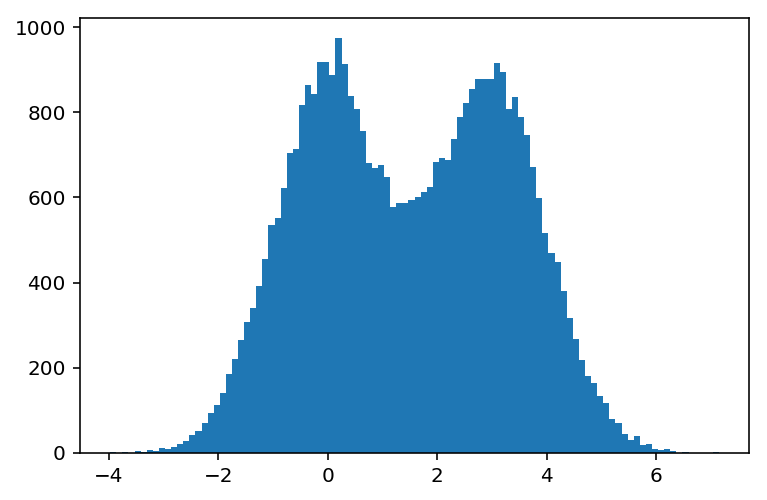

In [3]:
def generate_mixture_data(mus, sizes):
    """
    Generates mixture data
    """
    subpop1 = np.random.normal(loc=mus[0], scale=1, size=sizes[0])
    subpop2 = np.random.normal(loc=mus[1], scale=1, size=sizes[1])
    mixture = np.concatenate([subpop1, subpop2])
    return mixture

mixture = generate_mixture_data(mus=[0, 3], sizes=[20000, 20000])
plt.hist(mixture, bins=100)
plt.show()

Just to reiterate the point, one of the Gaussian distributions has a mean at 0, and the other has a mean at 3. Both subpopulations are present in equal proportions in the larger population, i.e. they have equal weighting.

Let's see if we can use PyMC3 to recover those parameters. Since we know that there are two mixture components, we can encode this in the model.

In [4]:
with pm.Model() as model:
    mu = pm.Cauchy('mu', alpha=1, beta=1, shape=(2,))
    sd = pm.HalfCauchy('sd', beta=1, shape=(2,))
    
    w = pm.Dirichlet('w', a=np.array([1, 1]))  # mixture component weights. See below!
    
    like = pm.NormalMixture('like', w=w, mu=mu, sd=sd, observed=mixture)

In [5]:
with model:
    trace = pm.sample(2000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
100%|██████████| 2500/2500 [01:59<00:00, 20.96it/s]


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f24e073d898>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x7f24e061d780>]], dtype=object)

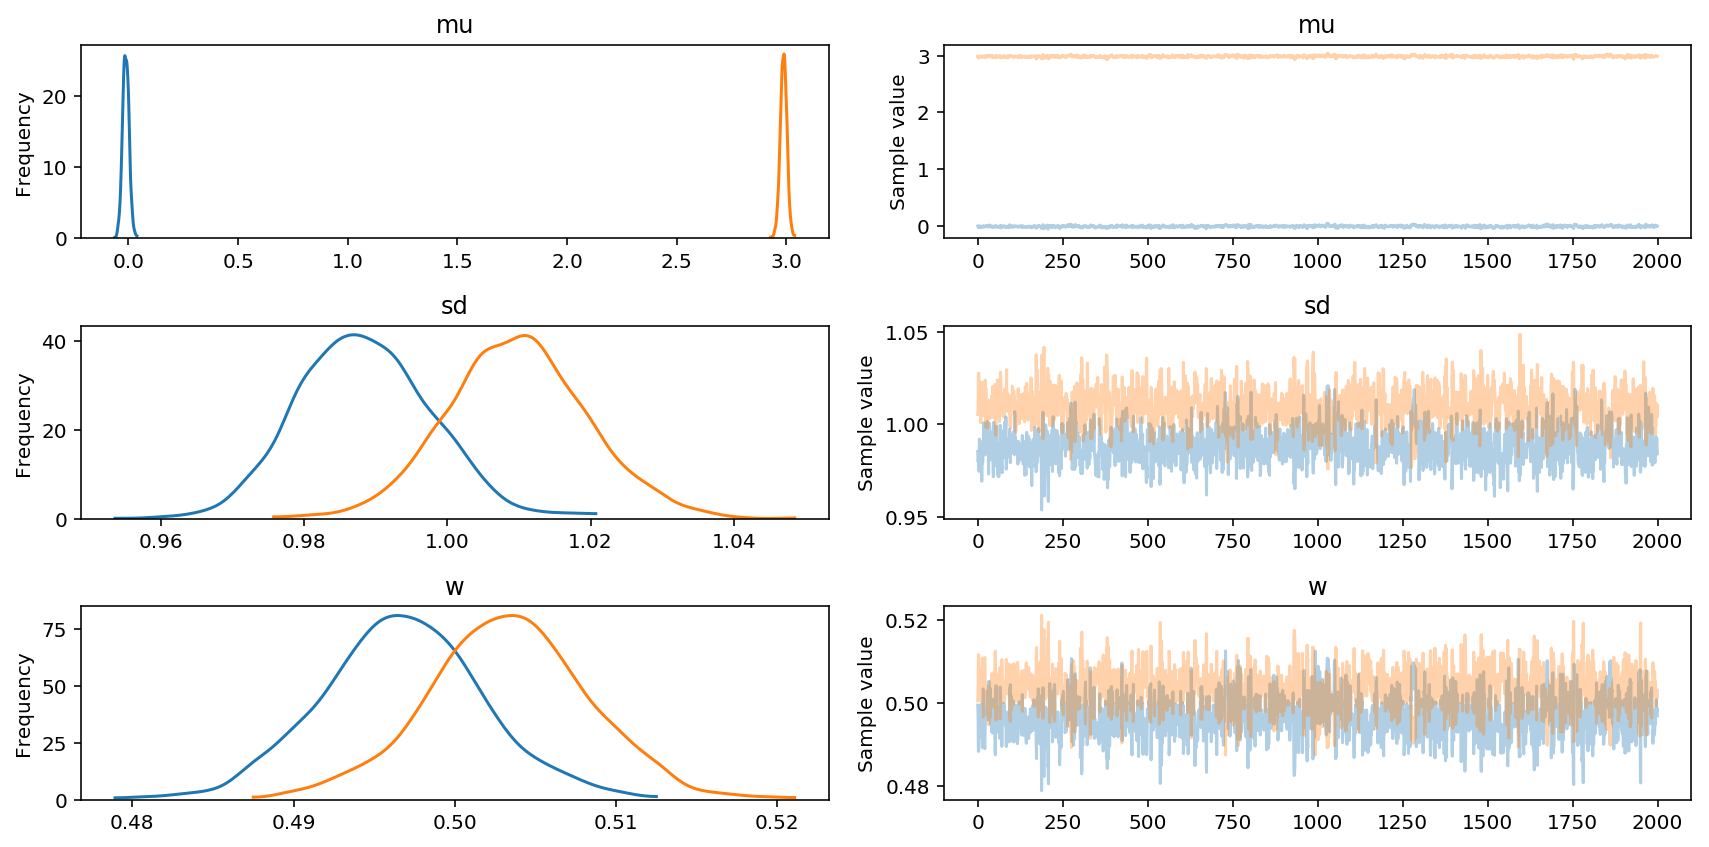

In [6]:
pm.traceplot(trace)

Now, sometimes, in our final population, one sub-population is present at a lower frequency than the other sub-population. Let's try to simulate that.

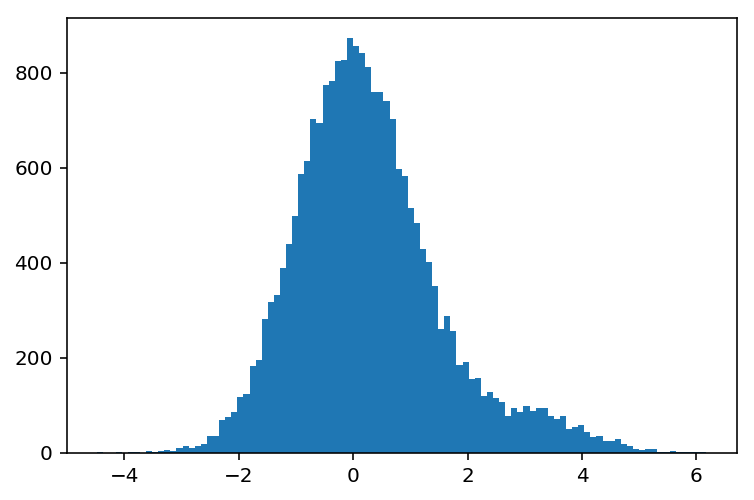

In [7]:
mixture = generate_mixture_data(mus=[0, 3], sizes=[20000, 2000])  # One is at 1/10 the size of the other.
plt.hist(mixture, bins=100)
plt.show()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
100%|██████████| 2500/2500 [01:33<00:00, 26.69it/s]


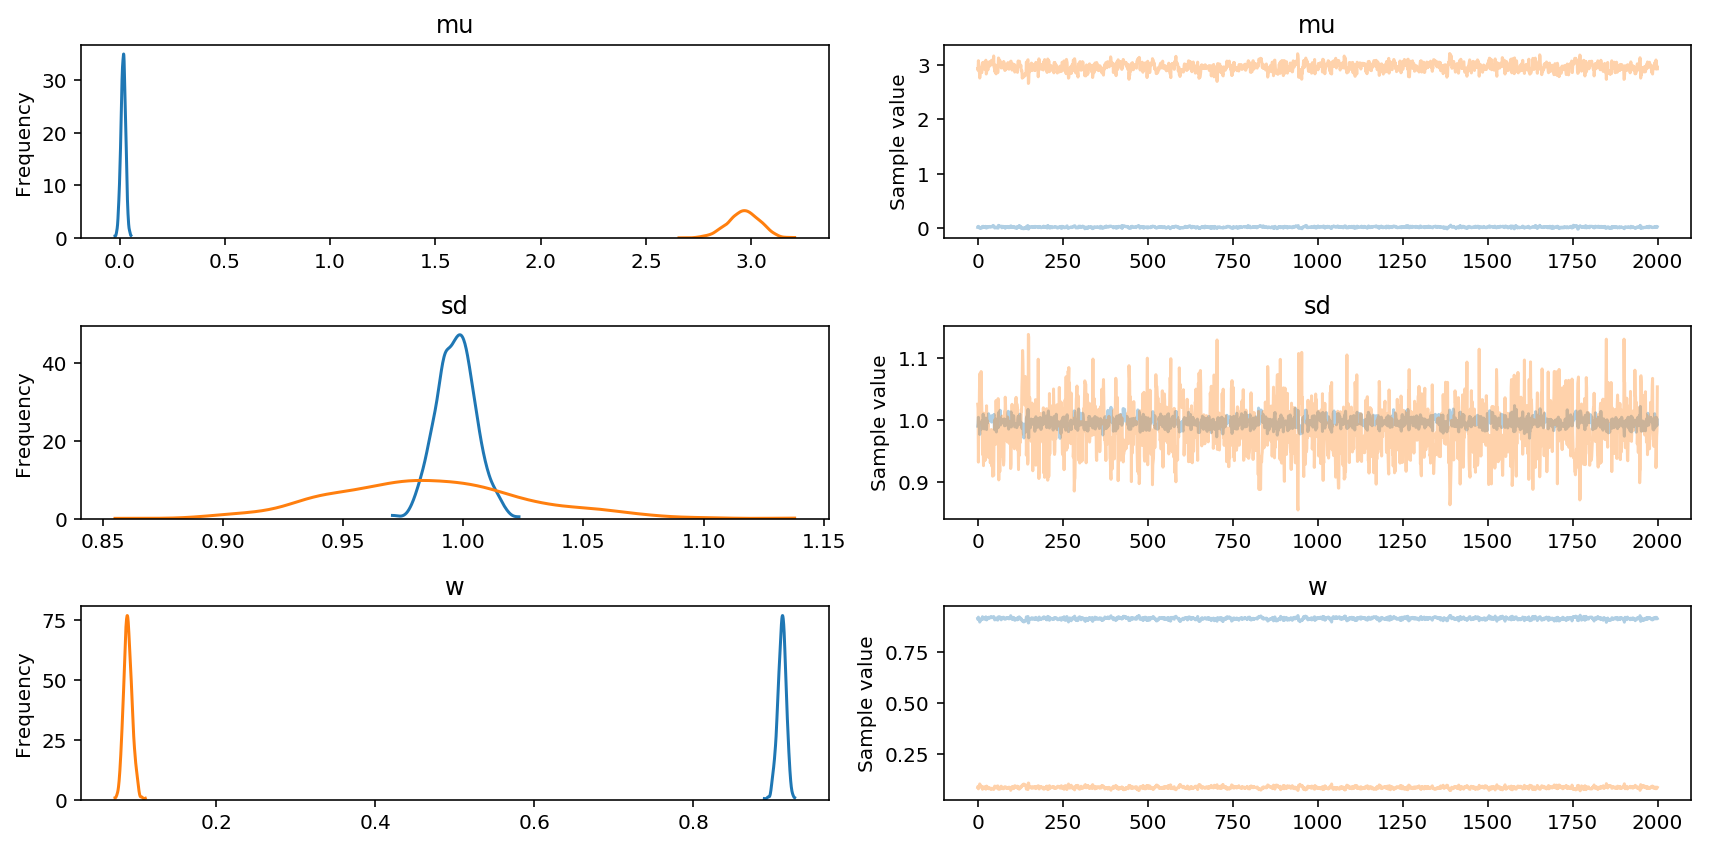

In [8]:
with pm.Model() as model:
    mu = pm.Cauchy('mu', alpha=1, beta=1, shape=(2,))
    sd = pm.HalfCauchy('sd', beta=1, shape=(2,))
    
    w = pm.Dirichlet('w', a=np.array([1, 1]))  # mixture component weights. See below!
    
    like = pm.NormalMixture('like', w=w, mu=mu, sd=sd, observed=mixture)

with model:
    trace = pm.sample(2000)
    pm.traceplot(trace)

This is really good. We have fewer samples for the group with $ \mu = 3 $, which thus means that we are much less confident about the value of $ \mu $ and $ \sigma $. What's neat is that we are nonetheless equally confident of the relative weighting of the two groups: one is much smaller in proportion than the other!

# Generalized Mixtures

We used Gaussian (a.k.a. Normal) distributions for generating the data. However, what if the data didn't come from a Gaussian distribution, but instead came from two Poissons?

In [28]:
def generate_poisson_mixtures(lams, sizes):
    grp1 = np.random.poisson(lam=lams[0], size=sizes[0])
    grp2 = np.random.poisson(lam=lams[1], size=sizes[1])
    
    mixture = np.concatenate([grp1, grp2])
    return mixture

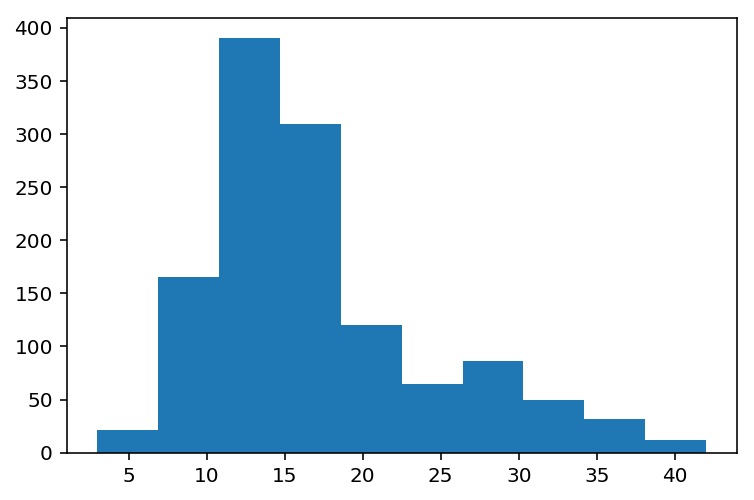

In [34]:
mixture = generate_poisson_mixtures(lams=[14, 30], sizes=[1000, 250])
plt.hist(mixture)
plt.show()

In [35]:
with pm.Model() as model:
    lam = pm.Exponential('lam', lam=1, shape=(2,))
    components = pm.Poisson.dist(mu=lam, shape=(2,))  # must use dist, not plain Poisson object!
    
    w = pm.Dirichlet('w', a=np.array([1, 1]))  # mixture component weights. See below!
    
    like = pm.Mixture('like', w=w, comp_dists=components, observed=mixture)

In [36]:
with model:
    trace = pm.sample(2000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
100%|██████████| 2500/2500 [00:11<00:00, 225.71it/s]


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f24e0c737b8>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x7f24c9c90240>]], dtype=object)

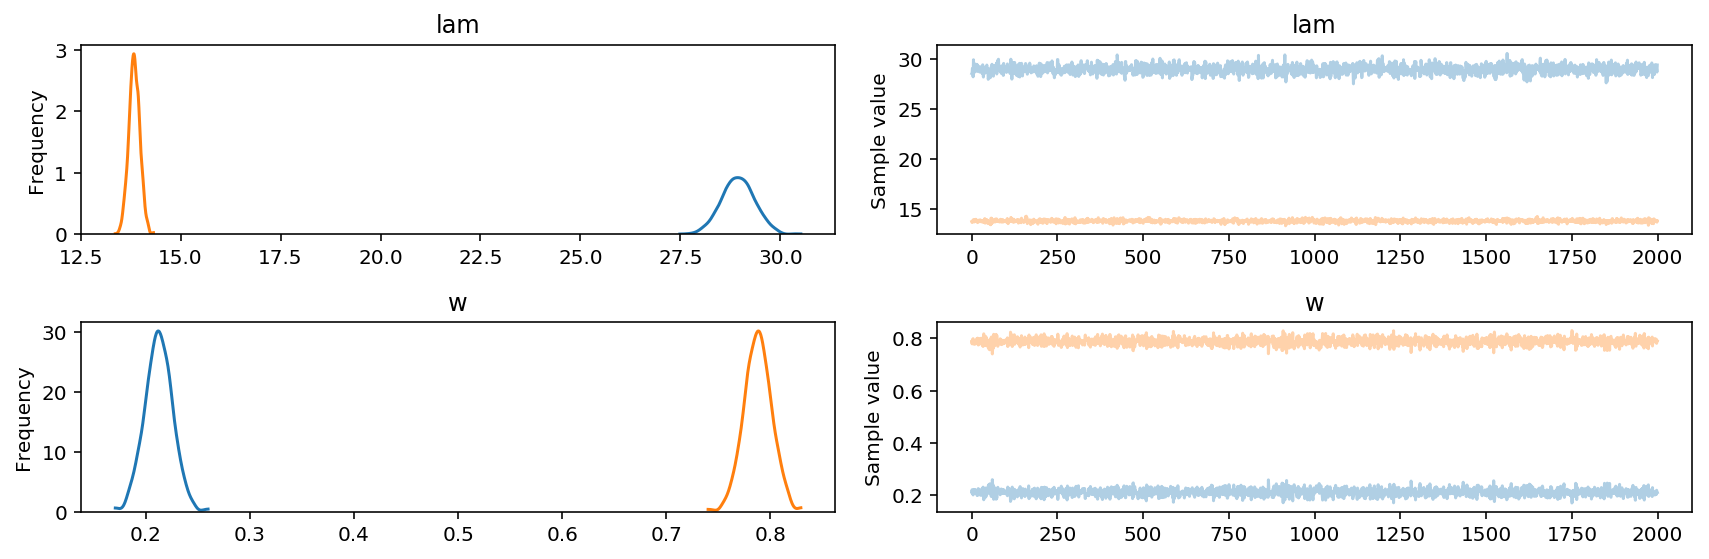

In [37]:
pm.traceplot(trace)

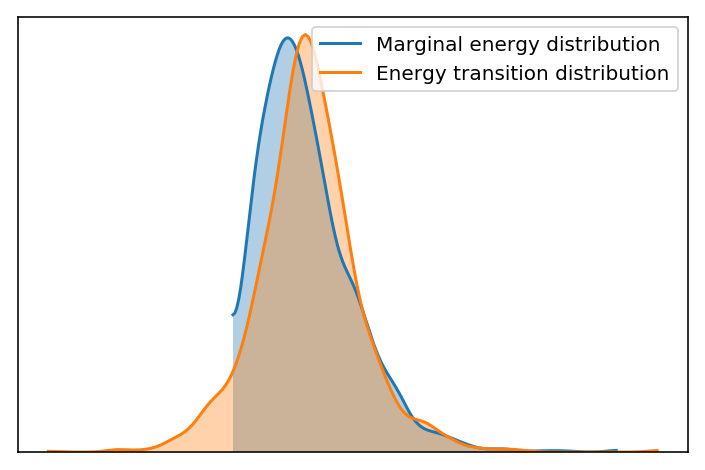

In [38]:
pm.energyplot(trace)

It worked! There was one minor detail that I had to learn from Junpeng Lao, who answered [my question](https://discourse.pymc.io/t/is-there-an-example-on-how-to-work-with-generalized-mixture-models/726) on the PyMC3 discourse site. That detail is this - that we have to use the `pm.Poisson.dist(...)` syntax, rather than `pm.Poisson(...)` syntax.

Now, what if we had much fewer data points? How would our confidence levels change?

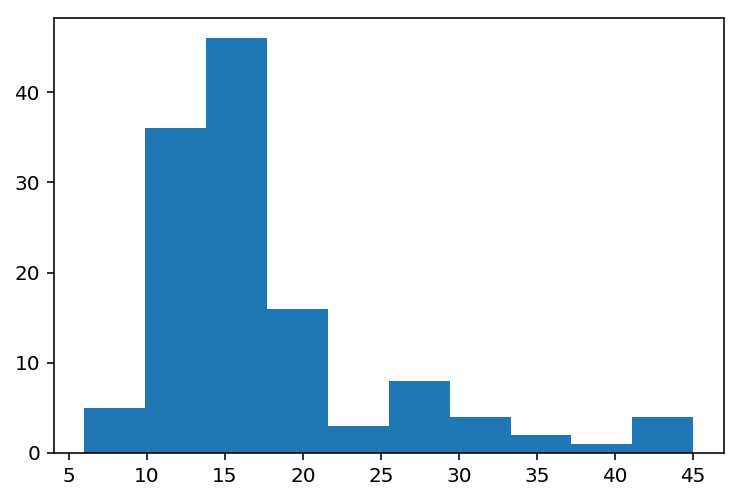

In [39]:
mixture = generate_poisson_mixtures(lams=[14, 30], sizes=[100, 25])
plt.hist(mixture)
plt.show()

In [40]:
with pm.Model() as model:
    lam = pm.Exponential('lam', lam=1, shape=(2,))
    components = pm.Poisson.dist(mu=lam, shape=(2,))  # must use dist, not plain Poisson object!
    
    w = pm.Dirichlet('w', a=np.array([1, 1]))  # mixture component weights. See below!
    
    like = pm.Mixture('like', w=w, comp_dists=components, observed=mixture)
    
    trace = pm.sample(2000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
100%|██████████| 2500/2500 [00:10<00:00, 237.47it/s]


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f24d3962940>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x7f24c9cf6438>]], dtype=object)

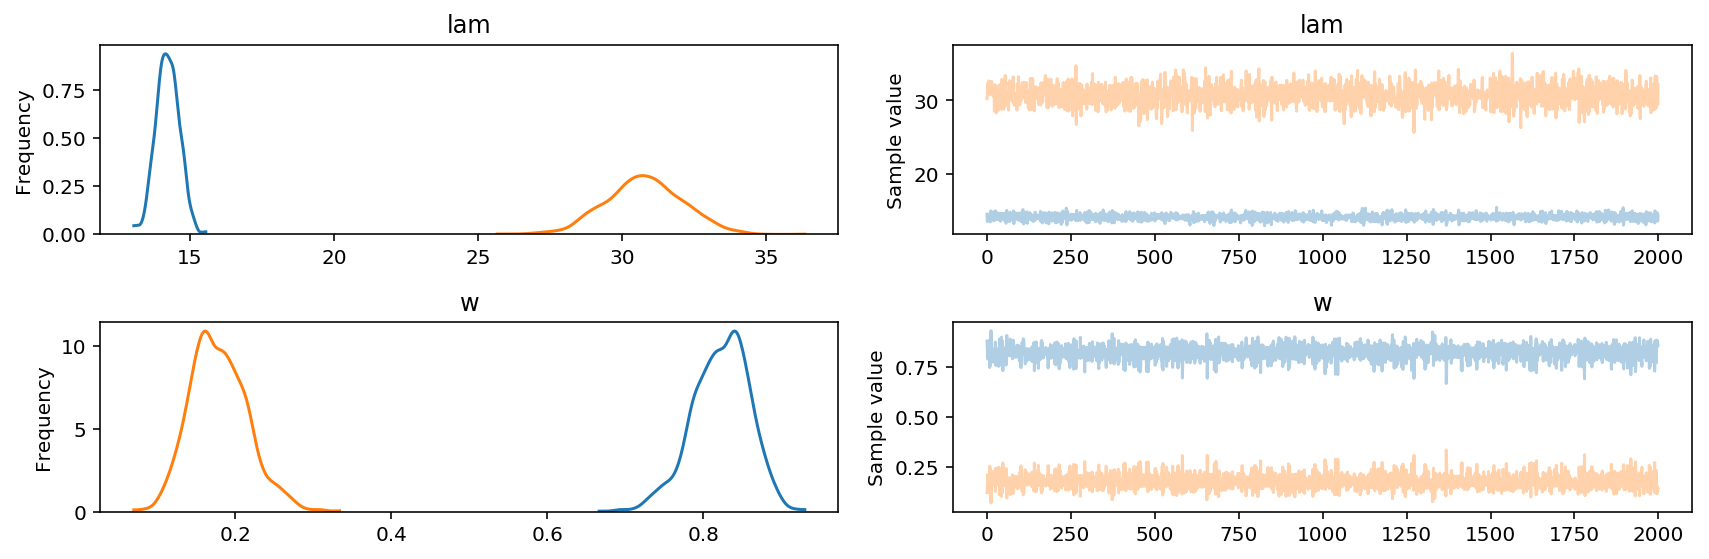

In [41]:
pm.traceplot(trace)

At ~100-ish data points, it's still not too hard to tell. What if we had fewer data points?

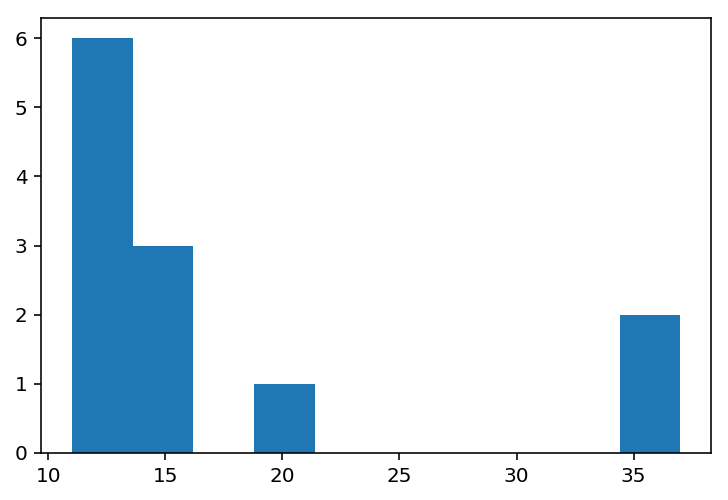

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
 99%|█████████▉| 2478/2500 [00:10<00:00, 225.85it/s]/home/ericmjl/anaconda/envs/bayesian/lib/python3.6/site-packages/pymc3/step_methods/hmc/nuts.py:451: UserWarning: The acceptance probability in chain 0 does not match the target. It is 0.880007527537, but should be close to 0.8. Try to increase the number of tuning steps.
  % (self._chain_id, mean_accept, target_accept))
100%|██████████| 2500/2500 [00:11<00:00, 225.81it/s]


In [42]:
mixture = generate_poisson_mixtures(lams=[14, 30], sizes=[10, 2])
plt.hist(mixture)
plt.show()

with pm.Model() as model:
    lam = pm.Exponential('lam', lam=1, shape=(2,))
    components = pm.Poisson.dist(mu=lam, shape=(2,))  # must use dist, not plain Poisson object!
    
    w = pm.Dirichlet('w', a=np.array([1, 1]))  # mixture component weights. See below!
    
    like = pm.Mixture('like', w=w, comp_dists=components, observed=mixture)
    
    trace = pm.sample(2000)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f24c973f1d0>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x7f24c92a7c50>]], dtype=object)

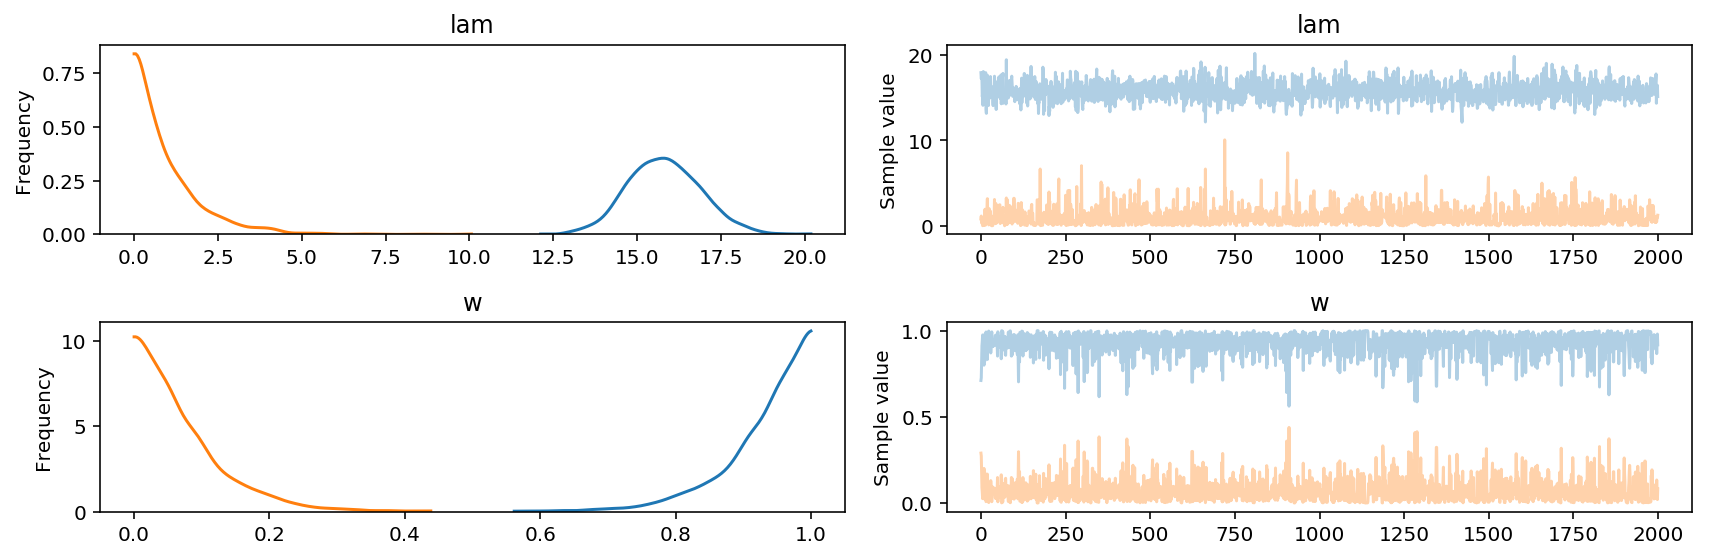

In [43]:
pm.traceplot(trace)

Model identifiability problems come in to play. `lam` parameters are very hard to estimate with little data. Moral of the story - get more data :)